# Homework

Juan Pablo Gomez Mendez - jupgomezme@unal.edu.co

Juan David Valencia Angulo - judvalenciaan@unal.edu.co

In [14]:
import math
import random
import numpy as np
import pandas as pd
import multiprocessing as mp
from functools import partial
from rich.progress import track
from rich.progress import Console
import matplotlib.pyplot as plt

console = Console()

Calculate the fitness

In [15]:
def fitness_tsp(path, tsp):
    # Return the cost of the path
    cost = 0
    for idx, city in enumerate(path[:-1]):
        cost += tsp[city, path[idx+1]]
    return -cost

Calculate neighbors

In [16]:
def neighbors(currentNode):
    """
    Returns a list of nodes, the neighbors of the currentNode.
    The neighbors are defined as the permutations of the nodes directly
    next to the others:
    For example, the neighbors of 1234 will be
    1234 -> 2134, 1324, 1243
    >>> sorted(neighbors([1,2,3,4]))
    [[1, 2, 4, 3], [1, 3, 2, 4], [2, 1, 3, 4]]
    """
    nodes = []

    for idx, _ in enumerate(currentNode[:-1]):
        copy = currentNode.copy()
        copy[idx], copy[idx+1] = copy[idx+1], copy[idx]
        nodes.append(copy)
    return nodes

# Random Restart Hill Climbing

States are a list of vertices represented by a list of integers. Each move is represented by a permutation between two elements. It uses multiprocessing for faster runtime.

In [17]:
def hill_climbing(current_node, tsp):
    while True:
        L = neighbors(current_node)
        next_eval = -float('inf')
        next_node = None
        for path in L:
            if fitness_tsp(path, tsp) > next_eval:
                next_node = path
                next_eval = fitness_tsp(path, tsp)
        if next_eval <= fitness_tsp(current_node, tsp):
            return current_node
        current_node = next_node

def random_restart_hill_climbing(tsp, **kwargs):
    """
    Run the random restart hill climbing algorithm

    Args:
        - tsp: Matrix representation of a graph that is an instance of the
        Traveling Salesman problem.
        - kwargs: Options for the algorithm. Meta-values

    Returns:
        - A possible solution of the TSP through the algorithm
    """
    # List of vertices V
    V = list(range(len(tsp)))

    # epoch: (number of hill-climbing instances)
    epoch = kwargs.get('epoch', 100)

    # Create a list for all possible initial states.
    nodes = list(map(lambda _: V.copy(), range(epoch)))

    # Each state is a list of vertices
    # a possible initial state is a permutation of the list of vertices
    # do random.shuffle to create a random permutation of the list of vertices
    # do that to each element in the list (each state) to create a list starting
    # points.
    for idx, _ in enumerate(nodes):
        random.shuffle(nodes[idx])

    # Use the library multiprocessing to save time (use all the processes)
    with mp.Pool(processes=kwargs.get('processes')) as executer:
        # Partial is used to create other function from other functions
        # f(x, y) = x + y...so partial(f, x=2) = 2 + y

        # imap is to have a iterative to keep track of the multiprocessing
        # track is a function from the rich library of python for printing the progress bar
        results = list(executer.imap(partial(hill_climbing, tsp=tsp), nodes))

    # Find the best path using max and the fitness as a key
    return max(results, key=lambda k: fitness_tsp(k, tsp))

## Simulated Annealing

Simulated annealing can use the same code base as the random restart hill climbing. Using classic temperature function.

In [18]:
def temperature(k, **kwargs):
    return (1 - (k+1)/kwargs.get('k_max'))*kwargs.get('temp_const')

def P(e, e_p, T):
    return math.exp((e_p - e)/T)

def simulated_annealing(tsp, **kwargs):
    """
    Simulated annealing
    """
    state = list(range(len(tsp)))
    random.shuffle(state)
    epoch = kwargs.get('epoch', 100)
    for k in range(epoch):
        T = temperature(k, k_max=(epoch), temp_const=kwargs.get('temp_const', 2))
        new_state = random.choice(neighbors(state))

        if P(fitness_tsp(state, tsp), fitness_tsp(new_state, tsp), T) >= random.random():
            #print(fitness_tsp(new_state, tsp))
            state = new_state
    return state

## Genetic Algorithm

Factorial function using dynamic memory

In [19]:
fact_memory = [1]

def fact(n: int) -> int:
    """
    Calculating factorial with dynamic programming.
    """
    if n == 0:
        return 1
    if n < len(fact_memory):
        return fact_memory[n]
    for i in range(len(fact_memory), n+1):
        fact_memory.append(i * fact_memory[i-1])
    return fact_memory[n]


Using integers to enumerate all possible permutations and bit-mask operations for mutation and crossover.

In [20]:
def decodification(genome, tsp):
    V = list(range(len(tsp)))
    solution = []
    for k in map(fact, reversed(range(len(tsp)))):
        selection = genome // k
        genome %= k
        #print(selection)
        solution.append( V.pop(selection) )
    return solution

def mutation(genome, tsp, **kwargs):
    binary_length = kwargs.get('binary_length', math.ceil(math.log2(fact(len(tsp)))))
    if kwargs.get('prob', 0.7) >= random.random():
        new_genome = genome ^ (1 << random.randint(0, binary_length - 1))
        while fact(len(tsp)) <= new_genome:
            new_genome = genome ^ (1 << random.randint(0, binary_length - 1))
        return new_genome
    return genome

def cross(genome_1, genome_2, tsp, **kwargs):
    binary_length = kwargs.get('binary_length', math.ceil(math.log2(fact(len(tsp)))))
    if kwargs.get('prob', 0.7) >= random.random():
        crossover_point = random.randint(0, binary_length - 1)
        mask_1 = (1 << crossover_point) - 1
        mask_2 = ((1 << binary_length) - 1 ) ^ mask_1
        child_one = (genome_1 & mask_1) | (genome_2 & mask_2)
        child_two = (genome_2 & mask_1) | (genome_1 & mask_2 )
        return [child_one, child_two]
    return [None, None]


Genetic Algorithm

In [21]:
def genetic_algorithm(tsp, **kwargs):
    V = list(range(len(tsp)))

    population = [random.randint(0, fact(len(tsp)) - 1) for _ in range(kwargs.get('population_size', 10))]
    population = [ ( fitness_tsp(decodification(genome, tsp), tsp), genome  ) for genome in population ]

    binary_length = math.ceil(math.log2(fact(len(tsp))))
    for _ in range(kwargs.get('epoch', 100)):
        new_population = []
        for idx, (fitness, genome) in enumerate(population):
             new_genome = mutation(genome, tsp)
             new_population.append( (fitness_tsp(decodification(new_genome, tsp), tsp), new_genome ) )
             if idx < len(population) - 1:
                _, next_genome = population[idx + 1]
                new_genome_1, new_genome_2 = cross(genome, next_genome, tsp)
                if new_genome_1 and new_genome_1 <= fact(len(tsp)):
                    new_population.append( (fitness_tsp(decodification(new_genome_1, tsp), tsp), new_genome_1) )
                if new_genome_2 and new_genome_2 <= fact(len(tsp)):
                    new_population.append( (fitness_tsp(decodification(new_genome_2, tsp), tsp), new_genome_2) )

        population += new_population
        population.sort(reverse=True)
        # Filter out to keep population
        population = population[:kwargs.get('offspring_size', 5)]
        for _ in range(len(population) - kwargs.get('population_size', 10)):
            random_genome = random.randint(0, fact(len(tsp)) - 1)
            population.append(( fitness_tsp(decodification(random_genome, tsp), tsp), random_genome  ))


    _, gen = max(population)
    solution = decodification(gen, tsp)
    return solution


## Random points of a circle

In [22]:
def generate_random_points(N):
    points = []
    for _ in range(N):
        r, theta = [500, 2*math.pi*random.random()]
        x = r * math.cos(theta)
        y = r * math.sin(theta)
        points.append((x, y))

    matrix = [ [0]*N for _ in range(N) ]
    for idx, (i,j) in enumerate(points):
        for idy, (m, l) in enumerate(points):
            matrix[idx][idy] = math.sqrt( (i - m)**2 + (j - l)**2 )
    return matrix

Run the script

Output()

/tmp/ipykernel_55890/1840356995.py:5: RuntimeWarning: divide by zero encountered in 
double_scalars
  return math.exp((e_p - e)/T)

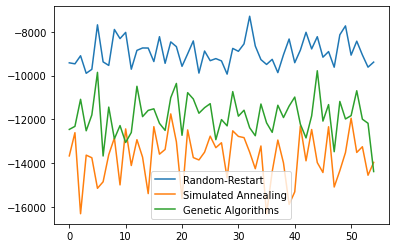

In [23]:
rrhc = []
sa = []
ga = []
for i in track(range(5,60)):
    c = np.array(generate_random_points(30))
    result = random_restart_hill_climbing(c, epoch=1000)
    rrhc.append(fitness_tsp(result, c))
    result = simulated_annealing(c, epoch=1000, temp_const=5.5)
    sa.append(fitness_tsp(result, c))
    result = genetic_algorithm(c, epoch=1000, population_size=40, offspring_size=30)
    ga.append(fitness_tsp(result, c))

info = pd.DataFrame([rrhc, sa, ga]).T
info.columns = ['Random-Restart', 'Simulated Annealing', 'Genetic Algorithms']
info.plot()
plt.show()

# Quadratic Assignment Problem

In [29]:
file_text = open('nug25.dat', 'r').read()
size = int(file_text.split('\n\n')[0].split('\n')[1].strip())
m_1 = file_text.split('\n\n')[1].split('\n')
m_2 = file_text.split('\n\n')[2].split('\n')

m_1 = list(map(lambda l: l.split(), m_1))
m_2 = list(map(lambda l: l.split(), m_2))

distances = np.array(m_1).astype(float)
flows = np.array(m_2).astype(float)

In [24]:
def fitness(solution):
    sum = 0
    for a in range(size):
        for b in range(size):
            sum += flows[a][b] * distances[solution[a]][solution[b]]
    return sum

Redefine functions for this problem

In [31]:
def decodification(genome):
    V = list(range(size))
    solution = []
    for k in map(fact, reversed(range(size))):
        selection = genome // k
        genome %= k
        #print(selection)
        solution.append( V.pop(selection) )
    return solution

def mutation(genome, **kwargs):
    binary_length = kwargs.get('binary_length', math.ceil(math.log2(fact(size))))
    if kwargs.get('prob', 0.7) >= random.random():
        new_genome = genome ^ (1 << random.randint(0, binary_length - 1))
        while fact(size) <= new_genome:
            new_genome = genome ^ (1 << random.randint(0, binary_length - 1))
        return new_genome
    return genome

def cross(genome_1, genome_2, **kwargs):
    binary_length = kwargs.get('binary_length', math.ceil(math.log2(fact(size))))
    if kwargs.get('prob', 0.7) >= random.random():
        crossover_point = random.randint(0, binary_length - 1)
        mask_1 = (1 << crossover_point) - 1
        mask_2 = ((1 << binary_length) - 1 ) ^ mask_1
        child_one = (genome_1 & mask_1) | (genome_2 & mask_2)
        child_two = (genome_2 & mask_1) | (genome_1 & mask_2 )
        return [child_one, child_two]
    return [None, None]


In [32]:
def genetic_algorithm(**kwargs):
    V = list(range(size))

    population = [random.randint(0, fact(size) - 1) for _ in range(kwargs.get('population_size', 10))]
    population = [ ( fitness(decodification(genome)), genome  ) for genome in population ]

    binary_length = math.ceil(math.log2(fact(size)))
    for _ in track(range(kwargs.get('epoch', 100))):
        new_population = []
        for idx, (fit, genome) in enumerate(population):
             new_genome = mutation(genome)
             for _ in range(kwargs.get('num_mutations', 10)):
                 new_genome = mutation(new_genome)
             new_population.append( (fitness(decodification(new_genome)), new_genome ) )
             if idx < 5:
                 _, next_genome = random.choice(population[:3] + population[-3:])
                 new_genome_1, new_genome_2 = cross(genome, next_genome)
                 if new_genome_1 and new_genome_1 <= fact(size):
                     new_population.append( (fitness(decodification(new_genome_1)), new_genome_1) )
                 if new_genome_2 and new_genome_2 <= fact(size):
                     new_population.append( (fitness(decodification(new_genome_2)), new_genome_2) )

        population += new_population


        # Filter out to keep population
        for _ in range(len(population) - kwargs.get('random_offspring')):
            random_genome = random.randint(0, fact(size) - 1)
            population.append(( fitness(decodification(random_genome)), random_genome  ))
        population.sort()
        #print(population)
        population = population[:kwargs.get('population_size')]



    _, gen = max(population)
    solution = decodification(gen)
    return solution

In [36]:
result = genetic_algorithm(epoch=1000, population_size=100, num_mutations=50, random_offspring=10)
print(result, fitness(result))

Output()

[24, 1, 14, 7, 0, 21, 13, 20, 15, 12, 10, 5, 4, 16, 19, 22, 8, 9, 23, 11, 18, 17, 2, 3, 6] 4302.0
